<a href="https://colab.research.google.com/github/HiImGabry/speech-recognition-representation-unica-dl/blob/issue-11/Filter_Banks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filter Banks

In [21]:
#importo le librerie
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import wave
import matplotlib.pyplot as plt

In [12]:
!wget --no-check-certificate 'https://cdn.discordapp.com/attachments/1209871752134529066/1249007689183268864/reduced_dataset.zip?ex=6667b6ce&is=6666654e&hm=ed971eaee27586811340cf43960d7599cf17c12a174bb2abb6bc0faa42cf7975&' -O ../reduced_dataset.zip
!unzip ../reduced_dataset.zip
!mv reduced_dataset ..

Streaming output truncated to the last 5000 lines.
  inflating: reduced_dataset/dataset/audio/right/b7a0754f_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b83c1acf_nohash_4.wav  
  inflating: reduced_dataset/dataset/audio/right/b8c48ffb_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/b93528e3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b959cd0c_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b97c9f77_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/bcdaa7a9_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/bd11a2e7_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/bdee441c_nohash_3.wav  


In [18]:
path = 'reduced_dataset/dataset/audio/yes/9f869f70_nohash_1.wav'
sample_rate, signal = scipy.io.wavfile.read(path)
signal = signal[0:int(sample_rate)]

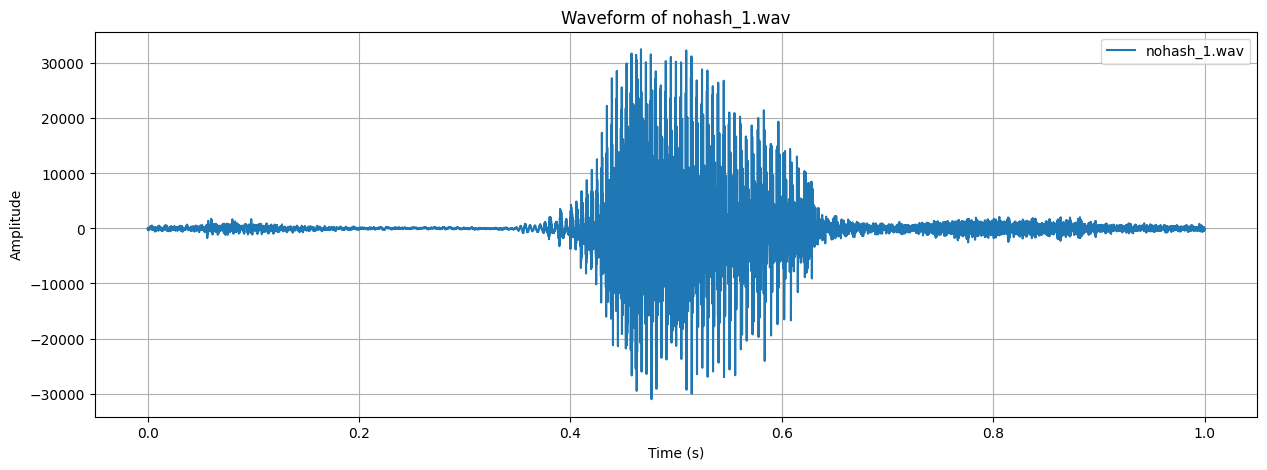

In [26]:
times = np.arange(len(signal)) / float(sample_rate)

audio = wave.open(path, "r").readframes(-1)
audio = np.frombuffer(audio, dtype=np.int16)

plt.figure(figsize=(15, 5))
plt.plot(times, signal, label='nohash_1.wav')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of nohash_1.wav')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
frame_stride = 0.01
frame_size = 0.025

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

frames *= np.hamming(frame_length)
#frames *= 0.54 - 0.46 * np.cos((2 * np.pi * 3) / (frame_length - 1))

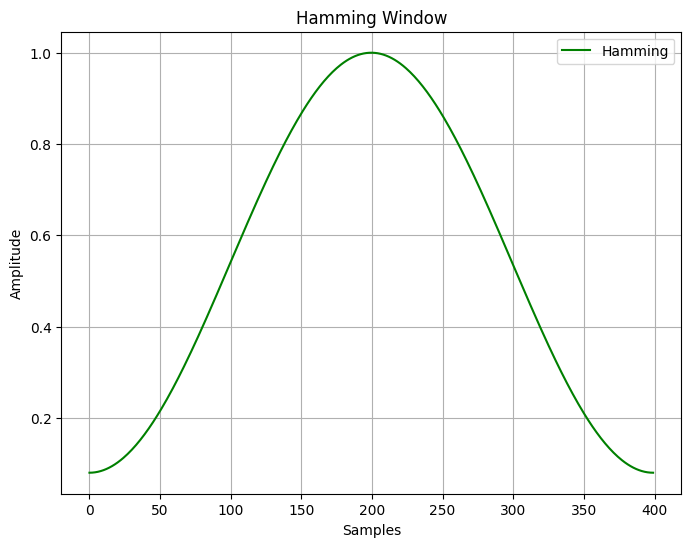

In [57]:
hamming_window = np.hamming(frame_length)

# Crea il grafico
plt.figure(figsize=(8, 6))
plt.plot(hamming_window, label='Hamming', color='green')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Hamming Window')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
NFFT = 512 #oppure 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

MEL min: 0
MEL max: 2146.06452750619


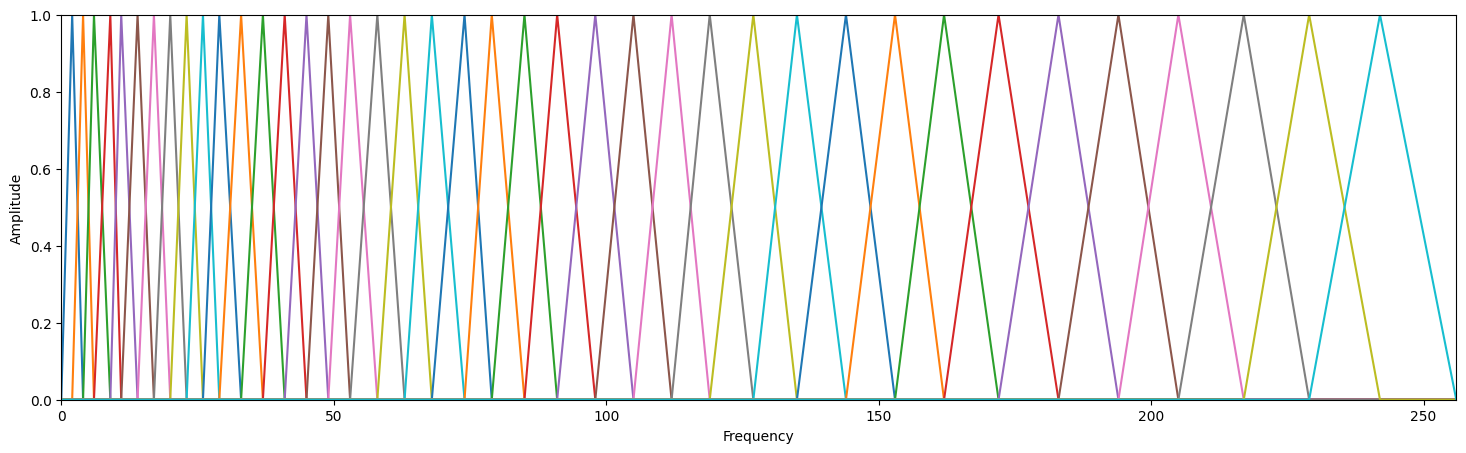

In [148]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

print("MEL min: {0}".format(low_freq_mel))
print("MEL max: {0}".format(high_freq_mel))

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

plt.figure(figsize=(18,5))
for n in range(fbank.shape[0]):
    plt.plot(fbank[n])
    plt.margins(x=0)
    plt.margins(y=0)
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency')